In [104]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import pymbar

from collections import namedtuple
%matplotlib inline

@jit
def perturbation(x):
    return 5 * x

@jit
def grad_perturbation(x):
    return 5

@jit
def potential(x, lam):
    return x**4 + lam * perturbation(x)

@jit
def grad_potential(x, lam):
    return 4 * x**3 + lam * grad_perturbation(x)

@jit
def force(x, lam):
    return - grad_potential(x, lam)

gamma = 10.0
beta = 1.0
m = 10.0
velocity_scale = np.sqrt(1.0 / (beta * m))
dt = 1.0

# Get the KL divergence ~exactly using numerical quadrature

@jit
def reduced_potential(x, lam):
    return potential(x, lam) * beta


@jit
def log_q(x, lam):
    return - reduced_potential(x, lam)


@jit
def q(x, lam):
    return np.exp(log_q(x, lam))


# normalized density
x_ = np.linspace(-10,10,10000)
Z_0 = np.trapz(q(x_, 0), x_)
log_Z_0 = np.log(Z_0)

Z_1 = np.trapz(q(x_, 1), x_)
log_Z_1 = np.log(Z_1)

def p0(x):
    return q(x, 0) / Z_0

def log_p0(x):
    return log_q(x, 0) - log_Z_0

def p1(x):
    return q(x, 1) / Z_1

def log_p1(x):
    return log_q(x, 1) - log_Z_1

exact_free_energy_difference = log_Z_0 - log_Z_1

@jit
def simulate_vvvr(x0, v0, lambdas):
    """Simulate VVVR with explicit hamiltonian updates,
    accumulating shadow work and protocol work"""
    n_steps = len(lambdas)
    W_prots = np.zeros(n_steps)
    W_shads = np.zeros(n_steps)
    
    x, v = x0, v0
    xs, vs = np.zeros(n_steps), np.zeros(n_steps)
    xs[0] = x0
    vs[0] = v0

    a = np.exp(- gamma * (dt / 2.0))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt / 2.0)))

    for i in range(1, n_steps):
        old_lambda = lambdas[i - 1]
        new_lambda = lambdas[i]

        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, old_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # half R step : shadow work
        pe_old = potential(x, old_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, old_lambda)
        W_shads[i] += (pe_new - pe_old)

        # update hamiltonian: protocol work
        W_prots[i] = potential(x, new_lambda) - potential(x, old_lambda)

        # half R step : shadow work
        pe_old = potential(x, new_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, new_lambda)
        W_shads[i] += (pe_new - pe_old)

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, new_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()
        
        xs[i] = x
        vs[i] = v
    
    return xs, vs, W_shads, W_prots


# draw samples from equilibrium
discard = 1000
@jit
def rw_metropolis_hastings(x0, n_steps, lam):
    xs = np.zeros(n_steps)
    xs[0] = x0

    # draw all the random numbers we'll need
    proposal_eps = np.random.randn(n_steps) # standard normal
    accept_eps = np.random.rand(n_steps) # uniform(0,1)

    for i in range(1, n_steps):
        x_prop = xs[i-1] + proposal_eps[i]
        a_r_ratio = q(x_prop, lam) / q(xs[i-1], lam)

        # accept / reject
        if a_r_ratio > accept_eps[i]:
            xs[i] = x_prop
        else:
            xs[i] = xs[i-1]
    return xs

n_steps = 10000000
xs = rw_metropolis_hastings(np.random.randn(), n_steps, 0)
pi_x_0 = xs[discard:]
pi_v_0 = np.random.randn(len(pi_x_0)) * velocity_scale

xs = rw_metropolis_hastings(np.random.randn(), n_steps, 1)
pi_x_1 = xs[discard:]
pi_v_1 = np.random.randn(len(pi_x_1)) * velocity_scale

# draw samples from nonequilibrium steady state
xs, vs, _, _ = simulate_vvvr(np.random.randn(), np.random.randn() * velocity_scale, np.zeros(n_steps))
rho_x_0, rho_v_0 = xs[discard:], vs[discard:]

xs, vs, _, _ = simulate_vvvr(np.random.randn(), np.random.randn() * velocity_scale, np.ones(n_steps))
rho_x_1, rho_v_1 = xs[discard:], vs[discard:]

# now, let's consider estimating the free energy difference from work measurements...

n_protocol_samples = 1000000


def simulate_protocol(initial_x_ensemble, initial_v_ensemble, protocol):
    i = np.random.randint(len(initial_x_ensemble))
    return simulate_vvvr(initial_x_ensemble[i], initial_v_ensemble[i], protocol)

Result = namedtuple("Result", ["forward_raw", "reverse_raw", "forward_corrected", "reverse_corrected"])


def collect_samples(ensemble="rho", protocol_length=100):
    # collect forward and reverse work values
    forward, reverse = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)
    forward_corrected, reverse_corrected = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)
    
    forward_protocol = np.linspace(0, 1, protocol_length)
    reverse_protocol = np.linspace(1, 0, protocol_length)
                    
    if ensemble == "rho":
        x_0, v_0 = rho_x_0, rho_v_0
        x_1, v_1 = rho_x_1, rho_v_1
        
    elif ensemble == "pi":
        x_0, v_0 = pi_x_0, pi_v_0
        x_1, v_1 = pi_x_1, pi_v_1

    for i in tqdm(range(n_protocol_samples)):
        _, _, W_shads_F, W_prots_F = simulate_protocol(x_0, v_0, forward_protocol)
        _, _, W_shads_R, W_prots_R = simulate_protocol(x_1, v_1, reverse_protocol)

        forward[i]  = np.sum(W_prots_F)
        reverse[i] = np.sum(W_prots_R)

        forward_corrected[i]  = np.sum(W_prots_F) + np.sum(W_shads_F)
        reverse_corrected[i] = np.sum(W_prots_R) + np.sum(W_shads_R)
    
    result = Result(forward, reverse, forward_corrected, reverse_corrected)
    return result


    
protocol_lengths = [2, 10, 100, 1000]
rho_results, pi_results = [], []
for protocol_length in protocol_lengths:
    rho_results.append(collect_samples("rho", protocol_length))
    pi_results.append(collect_samples("pi", protocol_length))

100%|██████████| 1000000/1000000 [04:01<00:00, 4143.37it/s]


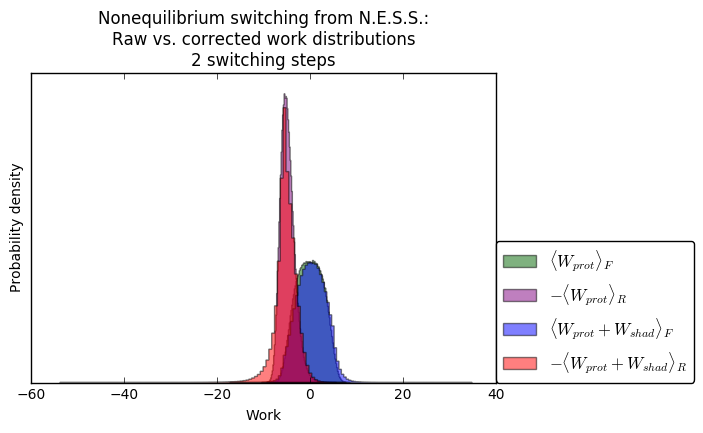

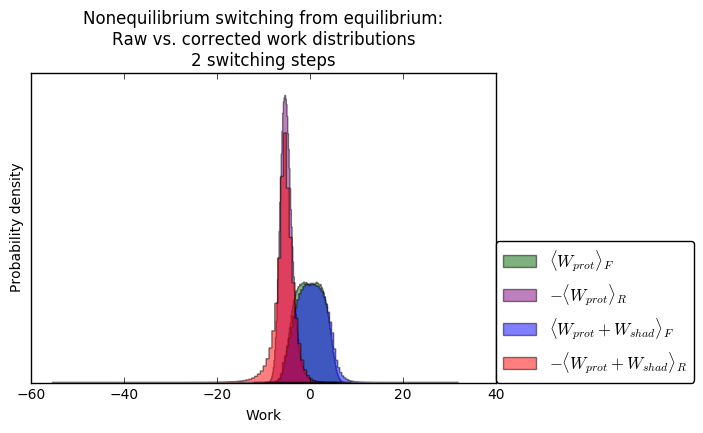

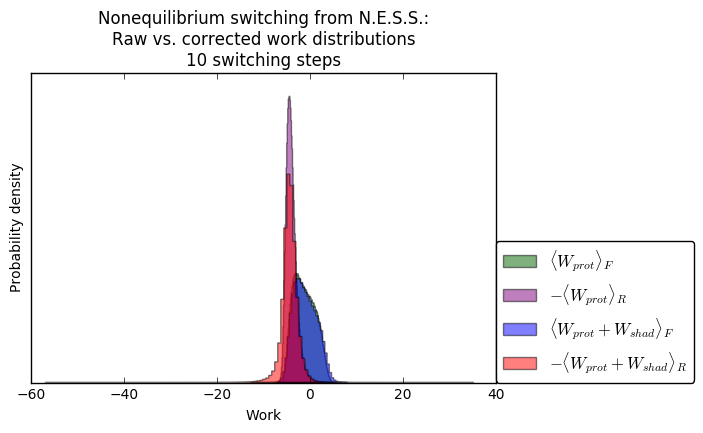

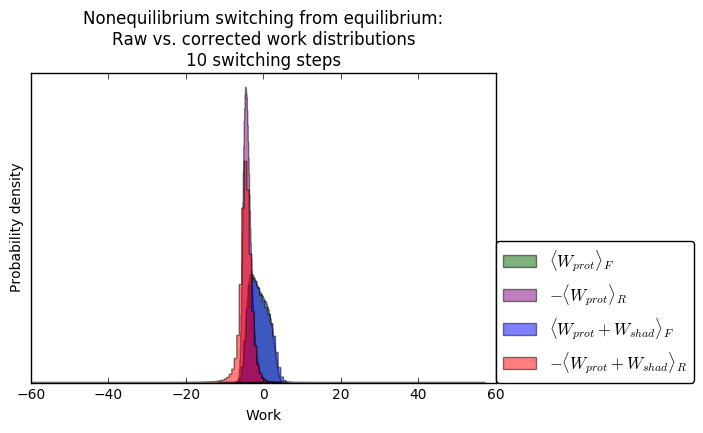

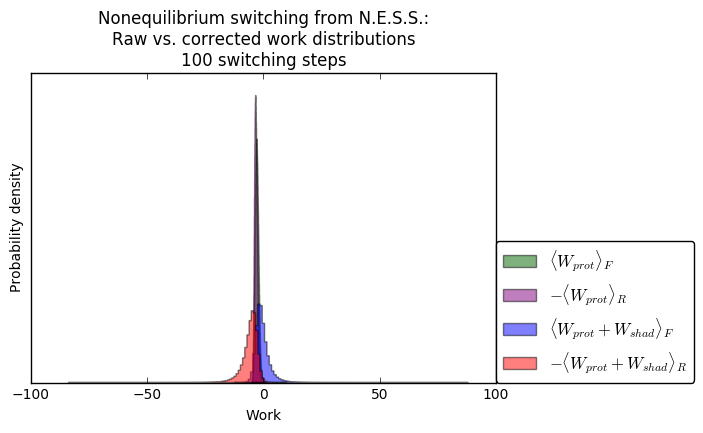

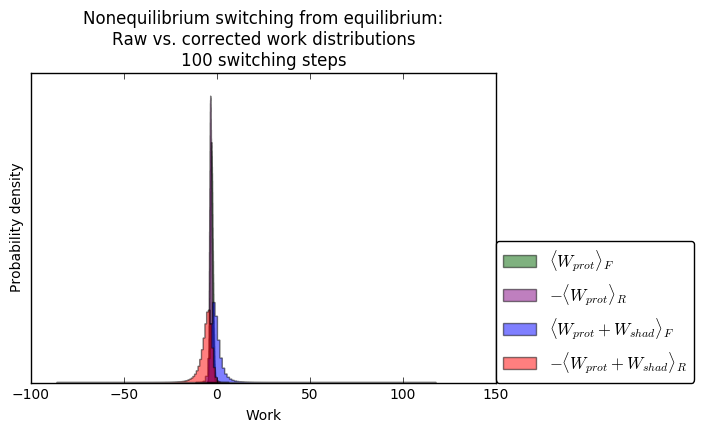

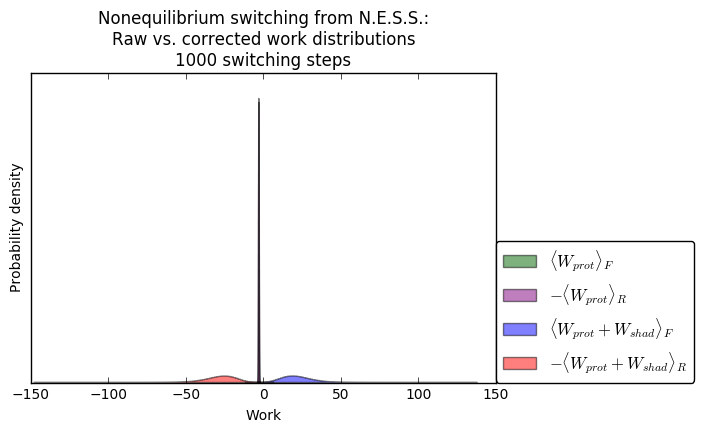

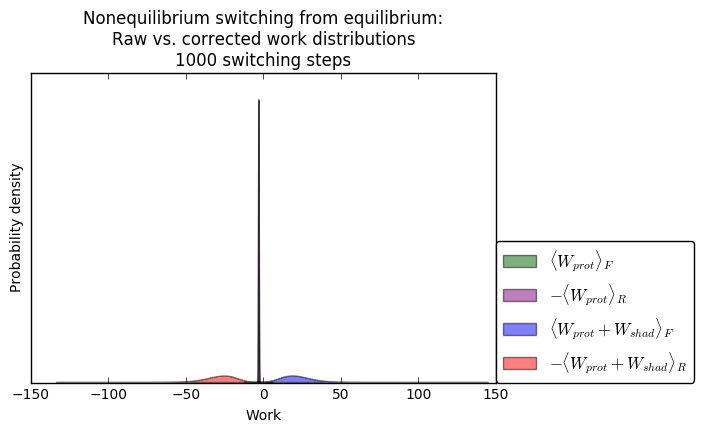

In [105]:
def plot_work_distributions(result):

    # Plot the forward and reverse protocol work
    hist_args = {"bins": 100, "alpha": 0.5, "histtype": "stepfilled", "normed": True}
    plt.hist(result.forward_raw, label=r"$\langle W_{prot} \rangle_F$", color="darkgreen", **hist_args);
    plt.hist(- result.reverse_raw, label=r"$- \langle W_{prot} \rangle_R$", color="purple", **hist_args);

    # Plot the forward and reverse protocol work + shadow work
    plt.hist(result.forward_corrected, label=r"$\langle W_{prot} + W_{shad} \rangle_F$", color="blue", **hist_args);
    plt.hist(- result.reverse_corrected, label=r"$- \langle W_{prot} + W_{shad} \rangle_R$", color="red", **hist_args);

    # Format
    plt.legend(loc=(1,0), fancybox=True)
    plt.title("Nonequilibrium switching:\nRaw vs. corrected work distributions")
    plt.xlabel("Work")
    plt.ylabel("Probability density")
    plt.yticks([])
    #plt.ylim(0,1)
    
    
for i in range(len(protocol_lengths)):
    plt.figure()
    plot_work_distributions(rho_results[i])
    plt.title("Nonequilibrium switching from N.E.S.S.:\nRaw vs. corrected work distributions\n{} switching steps".format(
            protocol_lengths[i]))
    
    plt.savefig('ness_work_dist_{}.jpg'.format(protocol_lengths[i]), dpi=300)
    
    plt.figure()
    plot_work_distributions(pi_results[i])
    plt.title("Nonequilibrium switching from equilibrium:\nRaw vs. corrected work distributions\n{} switching steps".format(
            protocol_lengths[i]))
    plt.savefig('eq_work_dist_{}.jpg'.format(protocol_lengths[i]), dpi=300)

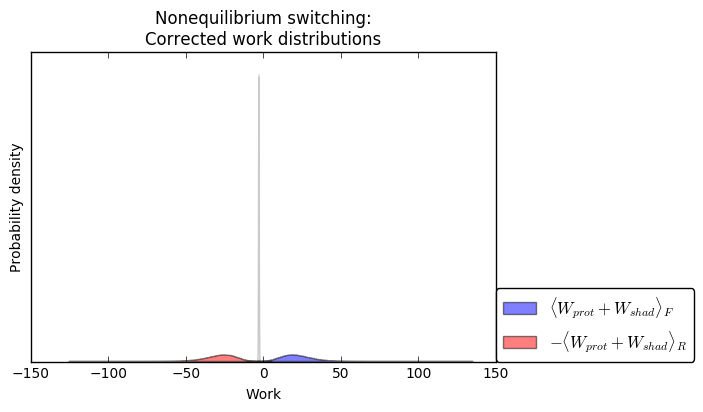

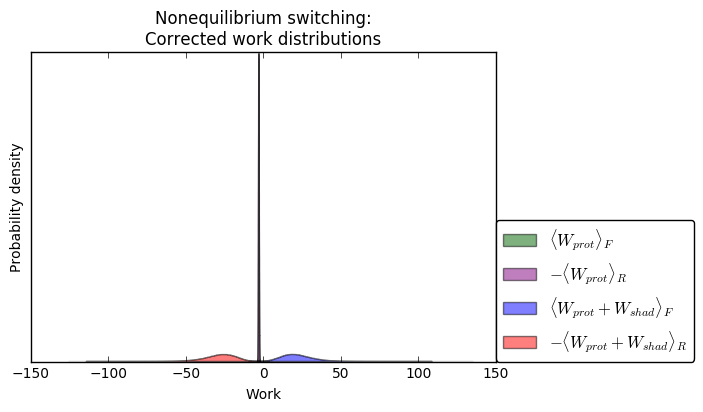

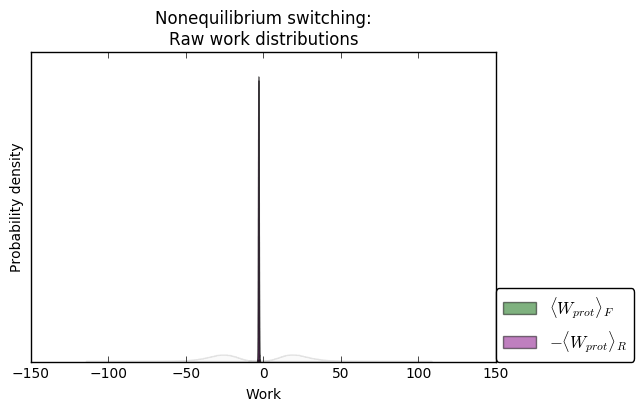

In [3]:
def plot_separately(result):

    # Plot the forward and reverse protocol work
    hist_args = {"bins": 100, "alpha": 0.5, "histtype": "stepfilled", "normed": True}
    hist_args["alpha"] = 0.1
    plt.hist(result.forward_raw, color="lightgrey", **hist_args);
    plt.hist(-result.reverse_raw, color="lightgrey", **hist_args);

    hist_args["alpha"] = 0.5
    # Plot the forward and reverse protocol work + shadow work
    plt.hist(result.forward_corrected, label=r"$\langle W_{prot} + W_{shad} \rangle_F$", color="blue", **hist_args);
    plt.hist(-result.reverse_corrected, label=r"$- \langle W_{prot} + W_{shad} \rangle_R$", color="red", **hist_args);

    # Format
    plt.legend(loc=(1,0), fancybox=True)
    plt.title("Nonequilibrium switching:\nCorrected work distributions")
    plt.xlabel("Work")
    plt.ylabel("Probability density")
    plt.yticks([])
    #plt.ylim(0,1)
    
    plt.figure()
    # Plot the forward and reverse protocol work
    hist_args = {"bins": 100, "alpha": 0.5, "histtype": "stepfilled", "normed": True}
    hist_args["alpha"] = 0.5
    plt.hist(result.forward_raw, label=r"$\langle W_{prot} \rangle_F$", color="darkgreen", **hist_args);
    plt.hist(-result.reverse_raw, label=r"$- \langle W_{prot} \rangle_R$", color="purple", **hist_args);

    # Plot the forward and reverse protocol work + shadow work
    hist_args["alpha"] = 0.1
    plt.hist(result.forward_corrected, color="lightgrey", **hist_args);
    plt.hist(-result.reverse_corrected, color="lightgrey", **hist_args);

    # Format
    plt.legend(loc=(1,0), fancybox=True)
    plt.title("Nonequilibrium switching:\nRaw work distributions")
    plt.xlabel("Work")
    plt.ylabel("Probability density")
    plt.yticks([])
    #plt.ylim(0,1)


plot_separately(rho_results[3])
plot_separately(pi_results[3])

In [106]:
def bootstrap_sample(samples, n_bootstrap_samples=100):
    """Draw n_bootstrap_samples with replacement from samples."""
    indices = np.random.randint(0, len(samples), n_bootstrap_samples)
    return samples[indices]

In [107]:
# plot estimate rmse as function of n_samples

n_sample_list = np.array(np.logspace(1, 5, 20), dtype=int)

def get_estimates(result, n_replicates=10):
    raw_estimates = np.zeros((n_replicates, len(n_sample_list)))
    corrected_estimates = np.zeros((n_replicates, len(n_sample_list)))

    for i in tqdm(range(n_replicates)):
        for j, n_samples in enumerate(n_sample_list):

            # just protocol work
            f_bootstrap = bootstrap_sample(result.forward_raw, n_samples)
            r_bootstrap = bootstrap_sample(result.reverse_raw, n_samples)

            raw_estimate, _ = pymbar.bar.BAR(f_bootstrap, r_bootstrap)
            raw_estimates[i, j] = raw_estimate

            # protocol work + shadow work
            f_bootstrap = bootstrap_sample(result.forward_corrected, n_samples)
            r_bootstrap = bootstrap_sample(result.reverse_corrected, n_samples)

            corrected_estimate, _ = pymbar.bar.BAR(f_bootstrap, r_bootstrap)
            corrected_estimates[i, j] = corrected_estimate
    
    return raw_estimates, corrected_estimates
n_sample_list

array([    10,     16,     26,     42,     69,    112,    183,    297,
          483,    784,   1274,   2069,   3359,   5455,   8858,  14384,
        23357,  37926,  61584, 100000])

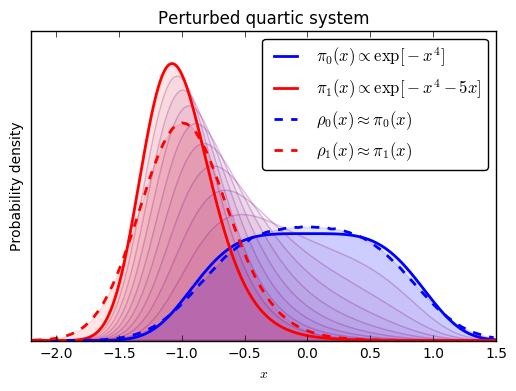

In [56]:
start_color = "blue"
middle_color = "purple"
end_color = "red"
linewidth=2


# equilibrium state at lambda = 0
plt.plot(x_, p0(x_), label=r"$\pi_0(x) \propto \exp[- x^4 ]$", color=start_color, linewidth=linewidth)
plt.fill_between(x_, p0(x_), alpha=0.1, color=start_color)

# equilibrium states at intermediate lambdas
for lam in np.linspace(0,1,10)[1:-1]:
    p_lam =  q(x_, lam) / np.trapz(q(x_, lam), x_)
    plt.plot(x_, p_lam, color=middle_color, alpha=0.2)
    plt.fill_between(x_, p_lam, alpha=0.05, color=middle_color)

# equilibrium state at lambda = 1
plt.plot(x_, p1(x_), label=r"$\pi_1(x) \propto \exp[ - x^4 - 5x ]$", color=end_color, linewidth=linewidth)
plt.fill_between(x_, p1(x_), alpha=0.1, color=end_color)


# also want to plot the N.E.S.S.
lim = (-2.2, 1.5)
rho_0, x_space_ = np.histogram(rho_x_0, bins=100, range=lim, normed=True)
rho_1, x_space_ = np.histogram(rho_x_1, bins=100, range=lim, normed=True)
x_space = x_space_[1:] - ((x_space_[1] - x_space_[0]) / 2.0)

# N.E.S.S. at lambda = 0
plt.plot(x_space, rho_0, label=r"$\rho_0(x) \approx \pi_0(x)$", color=start_color, linewidth=linewidth, linestyle='--')
plt.fill_between(x_space, rho_0, alpha=0.1, color=start_color)

# N.E.S.S. at lambda = 1
plt.plot(x_space, rho_1, label=r"$\rho_1(x) \approx \pi_1(x)$", color=end_color, linewidth=linewidth, linestyle='--')
plt.fill_between(x_space, rho_1, alpha=0.1, color=end_color)

plt.ylabel("Probability density")
plt.legend(loc="best", fancybox=True)
plt.yticks([])
plt.xlabel("$x$")
plt.xlim(*lim)
plt.title("Perturbed quartic system")
plt.savefig('toy_system.jpg', dpi=300)

In [88]:
# now, let's get the free energy difference between the rho distributions

integration_lim = -2.5, 2
rho_0_density, x_space_ = np.histogram(rho_x_0, bins=100, range=integration_lim, normed=True)
rho_1_density, x_space_ = np.histogram(rho_x_1, bins=100, range=integration_lim, normed=True)
x_space = x_space_[1:] - ((x_space_[1] - x_space_[0]) / 2.0)

# Okay so, let's measure the nonequilibrium free energy of each of the states, because that'll be easier...
# F = <E> - S / beta

mean_energy_0 = np.mean(potential(rho_x_0, 0))
mean_energy_1 = np.mean(potential(rho_x_1, 1))

# now entropy
def differential_entropy_integrand(density):
    return np.nan_to_num(density * np.log(density))

entropy_0 = - np.trapz(differential_entropy_integrand(rho_0_density), x_space)
entropy_1 = - np.trapz(differential_entropy_integrand(rho_1_density), x_space)

F_0 = mean_energy_0 - (entropy_0 / beta)
F_1 = mean_energy_1 - (entropy_1 / beta)
rho_free_energy_difference = F_1 - F_0
rho_free_energy_difference, exact_free_energy_difference

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply


(-3.0200840246272369, -3.0874619558305088)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


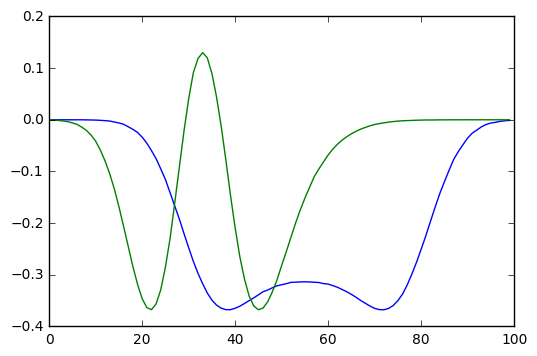

In [87]:
# Take a look at the differential entropy integrands... They look pretty reasonable / not dominated by
# sampling artifacts...
plt.plot(np.nan_to_num(rho_0_density * np.log(rho_0_density)))
plt.plot(np.nan_to_num(rho_1_density * np.log(rho_1_density)))

In [20]:
def plot_rmse(raw_estimates, corrected_estimates, ensemble="rho"):
    
    if ensemble == "rho":
        uncorrected_label = r"without shadow work ($\rho$)"
        corrected_label = r"with shadow work ($\rho$)"
    elif ensemble == "pi":
        uncorrected_label = r"without shadow work ($\pi$)"
        corrected_label = r"with shadow work ($\pi$)"

    plt.errorbar(n_sample_list,
                 np.sqrt(np.mean((raw_estimates - exact_free_energy_difference)**2, 0)),
                 np.std(np.abs(raw_estimates - exact_free_energy_difference), 0) / np.sqrt(len(raw_estimates)),
                 label=uncorrected_label)
    plt.errorbar(n_sample_list,
                 np.sqrt(np.mean((corrected_estimates - exact_free_energy_difference)**2, 0)),
                 np.std(np.abs(corrected_estimates - exact_free_energy_difference), 0) / np.sqrt(len(corrected_estimates)),
                 label=corrected_label)

    plt.hlines(0, min(n_sample_list), max(n_sample_list), linestyles='--')
    plt.ylabel("RMSE")
    plt.xlabel("# protocol samples")
    plt.legend(loc="best")
    plt.title("RMSE")

In [108]:
rho_estimates, pi_estimates = [], []

for i in range(len(protocol_lengths)):
    
    rho_estimates.append((get_estimates(rho_results[i], n_replicates=100)))
    pi_estimates.append((get_estimates(pi_results[i], n_replicates=100)))

100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


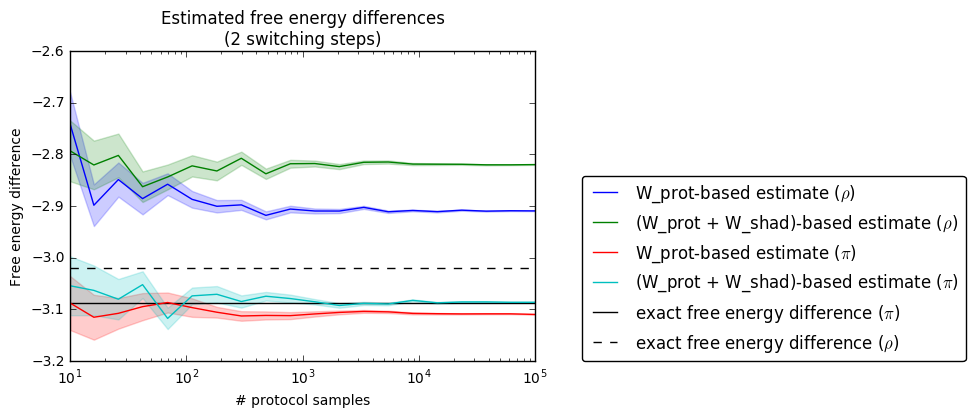

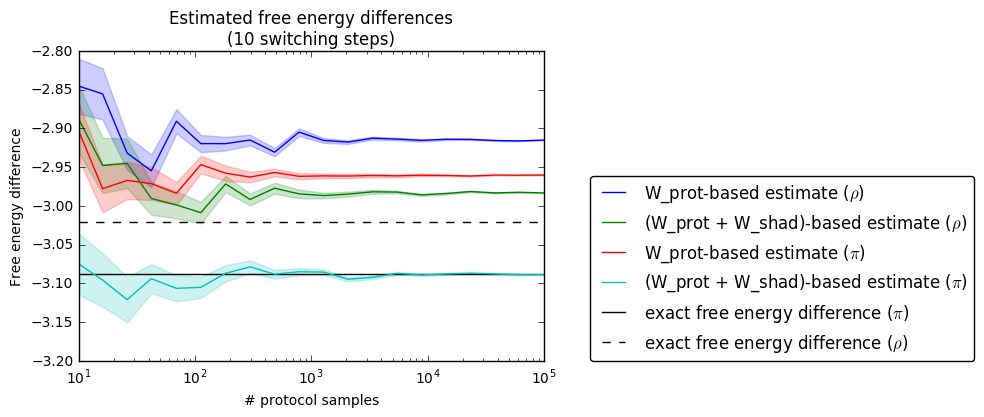

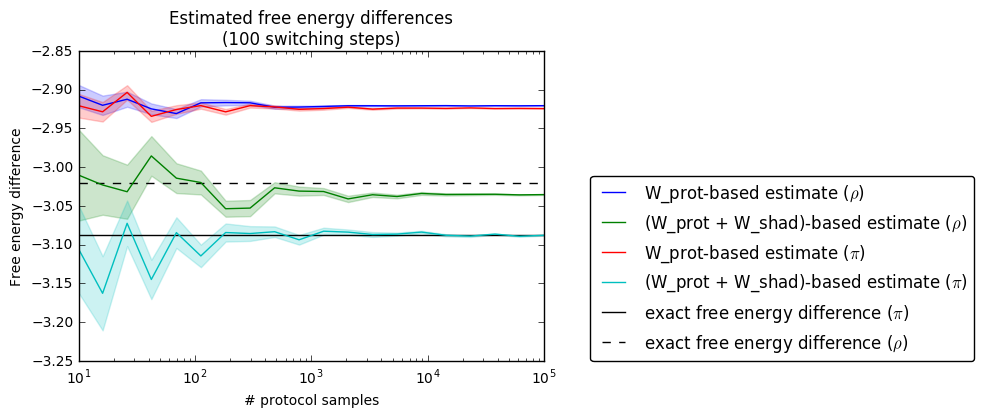

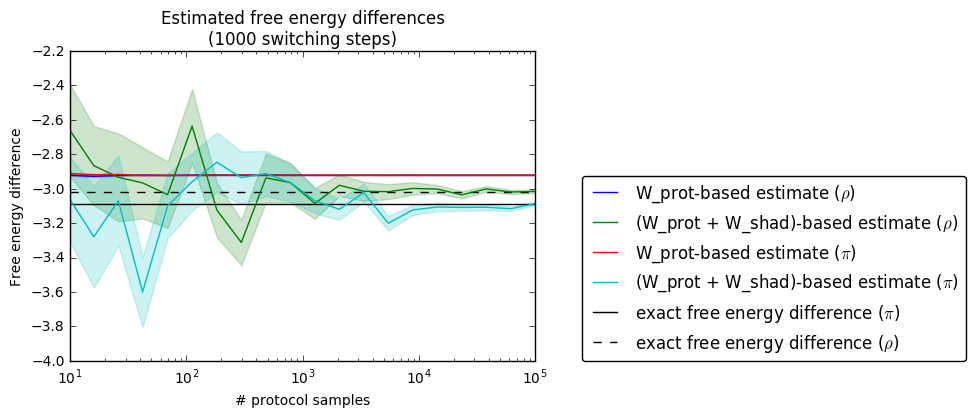

In [114]:
def plot_standard_error_band(x, ys, color="blue", label="", ):
    mean = np.mean(ys, 0)
    stderr = np.std(ys, 0) / np.sqrt(len(ys))
    
    plt.plot(x, mean, color=color, label=label)
    plt.fill_between(x, mean - stderr, mean + stderr, color=color, alpha=0.2)
    
for i in range(len(protocol_lengths)):
    plt.figure()
    plot_standard_error_band(n_sample_list, rho_estimates[i][0], color="blue", label=r"W_prot-based estimate ($\rho$)")
    plot_standard_error_band(n_sample_list, rho_estimates[i][1], color="green", label=r"(W_prot + W_shad)-based estimate ($\rho$)")

    plot_standard_error_band(n_sample_list, pi_estimates[i][0], color="red", label=r"W_prot-based estimate ($\pi$)")
    plot_standard_error_band(n_sample_list, pi_estimates[i][1], color="c", label=r"(W_prot + W_shad)-based estimate ($\pi$)")

    plt.hlines(exact_free_energy_difference, min(n_sample_list), max(n_sample_list), linestyle="-", label=r"exact free energy difference ($\pi$)")
    plt.hlines(rho_free_energy_difference, min(n_sample_list), max(n_sample_list), linestyle="--", label=r"exact free energy difference ($\rho$)")
    plt.xscale('log')
    plt.legend(loc=(1.1,0), fancybox=True)
    plt.xlabel("# protocol samples")
    plt.ylabel("Free energy difference")
    plt.title("Estimated free energy differences\n({} switching steps)".format(protocol_lengths[i]))
    plt.savefig("free_energy_estimates_{}.jpg".format(protocol_lengths[i]), dpi=300)

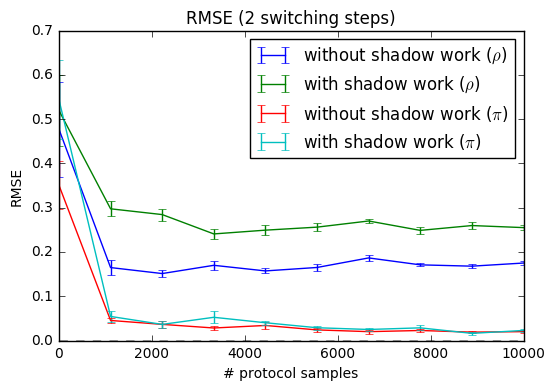

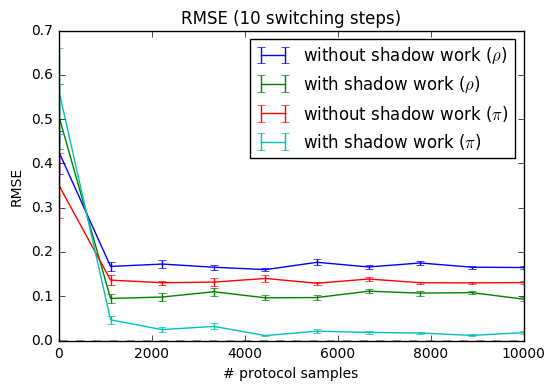

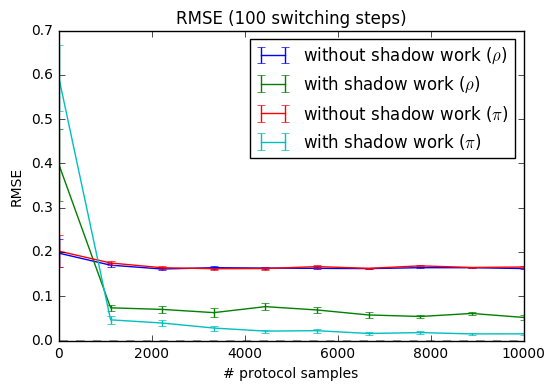

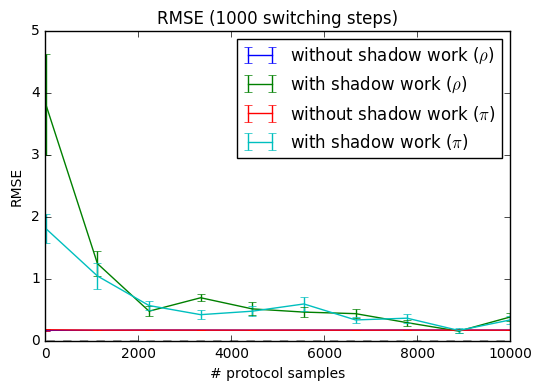

In [26]:
for i in range(len(protocol_lengths)):
    plt.figure()
    raw_estimates, corrected_estimates = rho_estimates[i]
    plot_rmse(raw_estimates, corrected_estimates, "rho")
    
    raw_estimates, corrected_estimates = pi_estimates[i]
    plot_rmse(raw_estimates, corrected_estimates, "pi")
    
    plt.title("RMSE ({} switching steps)".format(protocol_lengths[i]))
    plt.savefig('rmse_{}.jpg'.format(protocol_lengths[i]), dpi=300)

In [27]:
def plot_bias(raw_estimates, corrected_estimates, ensemble="rho"):
    if ensemble == "rho":
        uncorrected_label = r"without shadow work ($\rho$)"
        corrected_label = r"with shadow work ($\rho$)"
    elif ensemble == "pi":
        uncorrected_label = r"without shadow work ($\pi$)"
        corrected_label = r"with shadow work ($\pi$)"
        
    plt.plot(n_sample_list, np.mean(raw_estimates - exact_free_energy_difference, 0),
             label=uncorrected_label)
    plt.plot(n_sample_list, np.mean(corrected_estimates - exact_free_energy_difference, 0),
             label=corrected_label)

    plt.hlines(0, min(n_sample_list), max(n_sample_list))
    plt.ylabel("Estimate - actual")
    plt.xlabel("# protocol samples")
    plt.legend(loc="best", fancybox=True)
    plt.title("Bias")

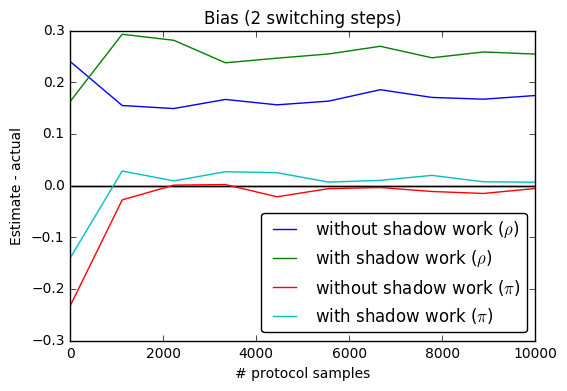

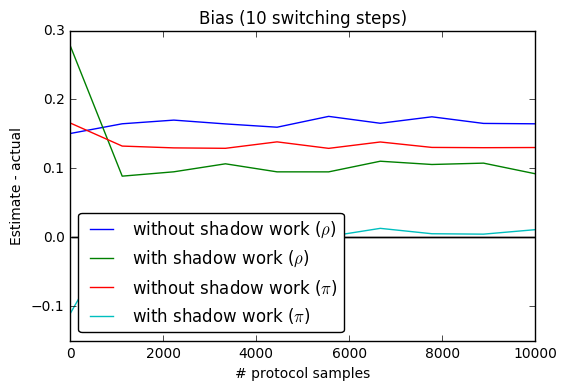

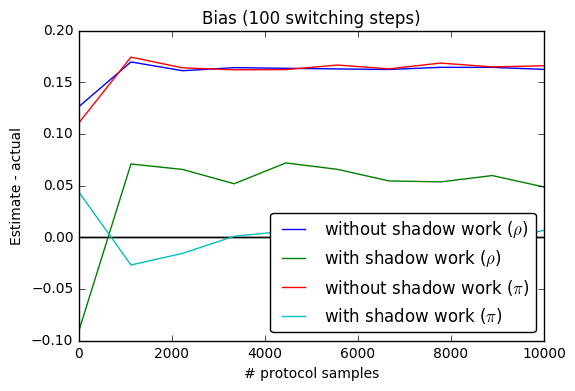

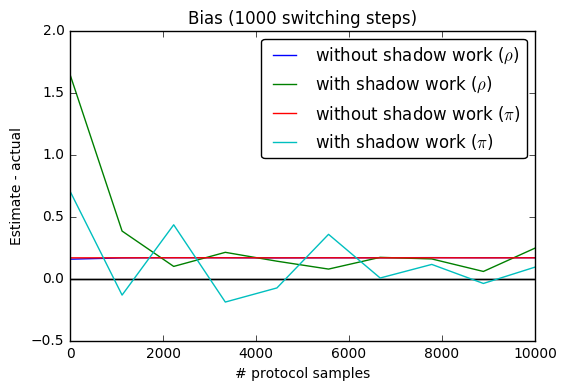

In [28]:
for i in range(len(protocol_lengths)):
    plt.figure()
    plot_bias(rho_estimates[i][0], rho_estimates[i][1], ensemble="rho")
    plot_bias(pi_estimates[i][0], pi_estimates[i][1], ensemble="pi")
    plt.title("Bias ({} switching steps)".format(protocol_lengths[i]))
    plt.savefig('bias_{}.jpg'.format(protocol_lengths[i]), dpi=300)